 ` ` 

<h4 style="text-align:center">Machine Exercise 1</h4>
<h3 style="text-align:center">Multiple Linear Regression</h3>


**Statement of the Problem:** <br>
A Real Estate Brokerage Firm needs to determine the reasonable selling price of the 100+ units of new properties that they just 
acquired. <br>
They have historical data of 300 units that they sold in the past and they have new 100+ units to be sold. <br> 
They want the pricing model of the new 100+ units to be consistent with the pricing of the units that they have sold in the past

**Dataset:**
- **No** - Property Number
- **P_Hse_Age** - Age of the house
- **P_DistMRT** - Distance from MRT
- **P_CntStores** - Number of Nearby Convenience Stores
- **P_Lat** - Latitude of the Property
- **P_Lon** - Longitude of the Property
- **Y_PriceArea** - Price per Square Meter

### Import Libraries

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Model Building and Model Evaluation Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import f_regression
from sklearn.feature_selection import r_regression

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Self-defined Functions
from skew_label import skew_label

In [2]:
# Defined functions for charts

def scatter_plot(df, X):
    fig, axes = plt.subplots(1,3, figsize = (20,7))
    plt.suptitle('Scatter Plot of Feature Variables', fontsize = 15, y = 1)

    for col, ax in zip(df[X], axes.flat):
        sns.scatterplot(data = df, x = col, y = 'Y_PriceArea', ax = ax)
        ax.set_title(f"{col} and Y_PriceArea\n Correlation: {round(df[[col, 'Y_PriceArea']].corr().values[0,1],3)}")
    plt.tight_layout()
    
    return plt.show()

def box_plot(df, X):
    fig, axes = plt.subplots(1,3, figsize = (20,7))
    plt.suptitle('Scatter Plot of Feature Variables', fontsize = 15, y = 1)

    for col, ax in zip(df[X], axes.flat):
        sns.boxplot(data = df, x = col, ax = ax)   
    plt.tight_layout()
    
    return plt.show()

def reg_plot(df, X):
    fig, axes = plt.subplots(1,3, figsize = (20,7))
    plt.suptitle('Regression Plot of Feature Variables', fontsize = 15, y = 1)

    for col, ax in zip(df[X], axes.flat):
        sns.regplot(data = df, x = col, y = 'Y_PriceArea', ax = ax)
        ax.set_title(f"{col} and Y_PriceArea\n Correlation: {round(df[[col, 'Y_PriceArea']].corr().values[0,1],2)}")
    plt.tight_layout()
   
    return plt.show()

def histogram(df, X):
    fig, axes = plt.subplots(1,3, figsize = (15,5))
    plt.suptitle('Distribution of Observations', fontsize = 15, y = 1)

    for col, ax in zip(df[X], axes.flat):
        #plot the histogram
        df[col].hist(bins = 20, grid = False, ax = ax)

        #chart formatting
        ax.axvline(x = df[col].mean(), color = 'red', label = 'Mean', linewidth = 2, linestyle = '--')
        ax.axvline(x = df[col].median(), color = 'green', label = 'Mean', linewidth = 2, linestyle = '-')    
        ax.set_title(f'{col}\nSkewness: {round(df[col].skew(),2)}\nSkew Label: {skew_label(df, col)}')
        ax.legend()

    plt.tight_layout()

    return plt.show()

def heatmap(df, X):
    plt.figure(figsize=(16,8))
    correlation = df[X].corr() 
    sns.heatmap(correlation, annot = True)

    plt.title('\nCorrelation Heatmap\n', fontsize = 15)
    plt.yticks(rotation = 360)
    return plt.show()

# Defined functions for other tasks

def removeoutliers(df, column_name = ""):
        iqr = df[column_name].quantile(.75) - df[column_name].quantile(.25)
        lowerbound = (df[column_name].quantile(.25)) - iqr * 1.5
        upperbound = (df[column_name].quantile(.75)) + iqr * 1.5
        lowerbound_outliers = df[df[column_name] < lowerbound]
        higherbound_outliers = df[df[column_name] > upperbound]
        outliers = pd.concat([lowerbound_outliers,higherbound_outliers])
        normal = df[~ df.index.isin(outliers.index)]
        return normal

def best_transformation(df, col):
    log_transform = np.log(df[col])
    box_transform = stats.boxcox(df[col])
    sqrt_transform = np.sqrt(df[col])
    no_transform = df[col]

    corr = {}
    corr['Log Transformation'] = np.round(np.corrcoef(log_transform, df['Y_PriceArea'])[1][0],2)
    corr['Boxcox Transformation'] = np.round(np.corrcoef(box_transform[0], df['Y_PriceArea'])[1][0],2)
    corr['Square Root Transformation'] = np.round(np.corrcoef(sqrt_transform, df['Y_PriceArea'])[1][0],2)
    corr['No Transformation'] = np.round(np.corrcoef(no_transform, df['Y_PriceArea'])[1][0],2)

    return corr

def f(r2, n, k):
    value = (r2/(1-r2))*((n-k-1)/k)
    
    return value

def evaluate(X_train, y_train, y_test, y_pred, model):
    r2 = r2_score(y_test, y_pred)
    _, p_value = f_regression(X_train, y_train)
    p_value = np.array2string(p_value)
    p_value = p_value.replace('[','').replace(']','').replace("'", "").split(' ')
    p_val1 = p_value[0]
    p_val2 = p_value[1]
    p_val3 = p_value[2]
    fstat = f(r2, X_train.shape[0], X_train.shape[1])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    eval = pd.DataFrame(index = ['F-Statistic',
                                 'P-Value_X1', 'P-Value_X2', 'P-Value_X3',
                                 'R-Squared',
                                 'RMSE'])
    eval.insert(0, model, [fstat, p_val1, p_val2, p_val3, r2, rmse])
    
    return eval

### Data Understanding

#### Data Validation

**Import Dataset**

In [3]:
house_sold = pd.read_excel('HousePrice_Sold.xlsx')
house_sold.head()

,No,P_Hse_Age,P_DistMRT,P_CntStores,P_Lat,P_Lon,Y_PriceArea
0,31,25.9,4519.690,0,24.94826,121.49587,22.1
1,36,13.9,4079.418,0,25.01459,121.51816,27.3
2,41,13.6,4082.015,0,24.94155,121.50381,15.9
3,42,16.8,4066.587,0,24.94297,121.50342,18.2
4,49,24.2,4605.749,0,24.94684,121.49578,13.4


**Data Basic Statistics**

In [4]:
house_sold.describe()

,No,P_Hse_Age,P_DistMRT,P_CntStores,P_Lat,P_Lon,Y_PriceArea
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,150.000000,17.804348,1091.981748,4.107023,24.968967,121.533388,38.004682
std,86.458082,11.298637,1280.328582,2.907163,0.012527,0.015436,13.926323
min,1.000000,0.000000,23.382840,0.000000,24.932930,121.475160,7.600000
25%,75.500000,9.900000,299.796250,1.000000,24.963010,121.527600,27.000000
50%,150.000000,16.200000,492.231300,4.000000,24.971100,121.538850,39.100000
75%,224.500000,28.100000,1410.633500,6.000000,24.977450,121.543480,46.750000
max,299.000000,43.800000,6396.283000,10.000000,25.014590,121.566270,117.500000


**Data Types**

In [5]:
house_sold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No           299 non-null    int64  
 1   P_Hse_Age    299 non-null    float64
 2   P_DistMRT    299 non-null    float64
 3   P_CntStores  299 non-null    int64  
 4   P_Lat        299 non-null    float64
 5   P_Lon        299 non-null    float64
 6   Y_PriceArea  299 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 16.5 KB


**Missing Values**

In [6]:
house_sold.isna().sum()

No             0
P_Hse_Age      0
P_DistMRT      0
P_CntStores    0
P_Lat          0
P_Lon          0
Y_PriceArea    0
dtype: int64

**Drop Unnecessary Columns**

In [7]:
house_sold = house_sold.drop(columns = 'No')
house_sold_Xy = house_sold.drop(columns = ['P_Lat', 'P_Lon'])

**Define `features` columns**

In [8]:
X = ['P_Hse_Age', 'P_DistMRT', 'P_CntStores']

#### Data Visualization

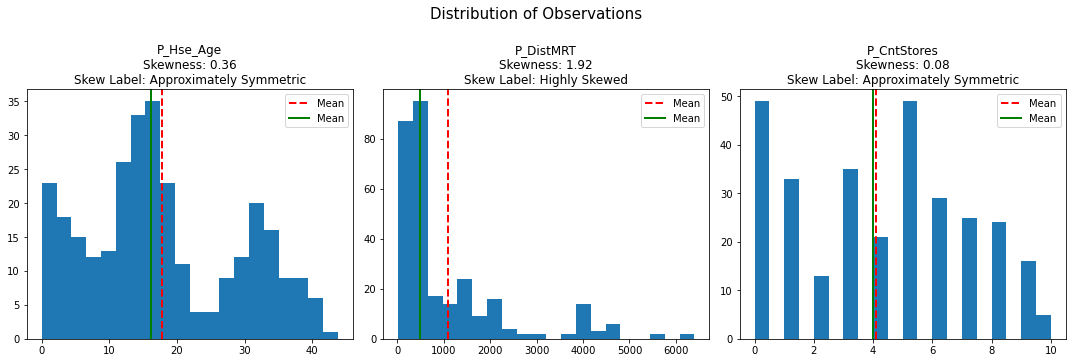

In [9]:
# distribution of observation in feature variables

histogram(house_sold, X)

The distribution for `P_Hse_Age` and `P_CntStores` are Approximately Symmetric while the distribution for `P_DistMRT` is highly skewed based on the computed skew values

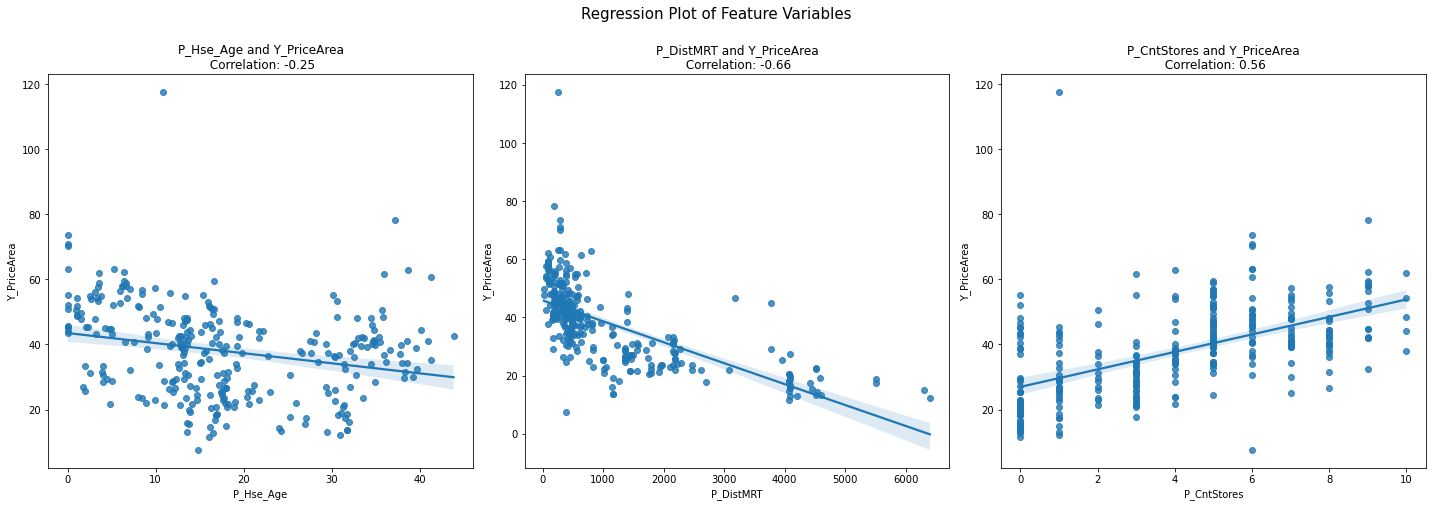

In [10]:
# regression plot of features with target variable

reg_plot(house_sold, X)

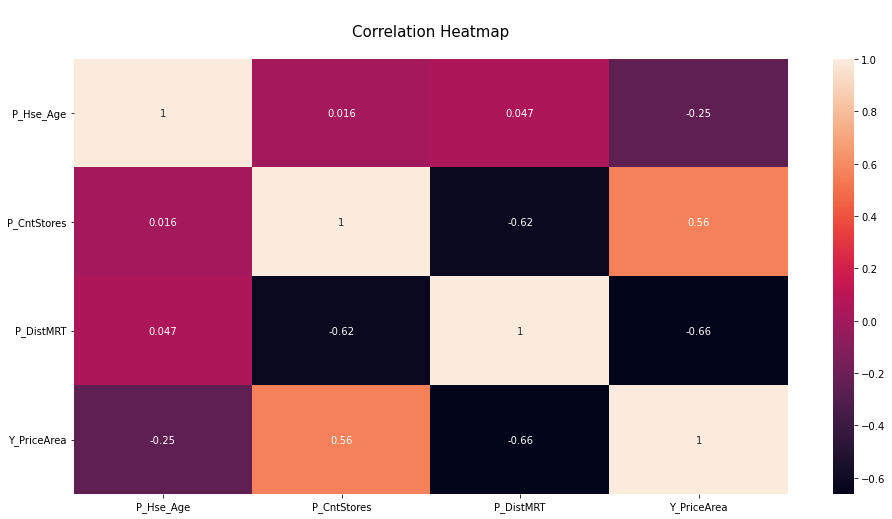

In [11]:
# correlation heatmap of feature and target variables

heatmap(house_sold_Xy, ['P_Hse_Age', 'P_CntStores', 'P_DistMRT', 'Y_PriceArea'])

`P_Hse_Age` and `P_CntStores` has a weak linear relationship with `Y_PriceArea` while `P_DistMRT` has a moderately strong negative linear relationship with `Y_PriceArea`. <br><br>This means that the `P_DistMRT` is a key feature that influences the price of a property. The lesser the distance is with MRT Stations, the higher the prices of the properties are.

### Data Preparation

#### Checking of Assumptions - Part 1

##### Linearity

**Linearity Test - Validation**

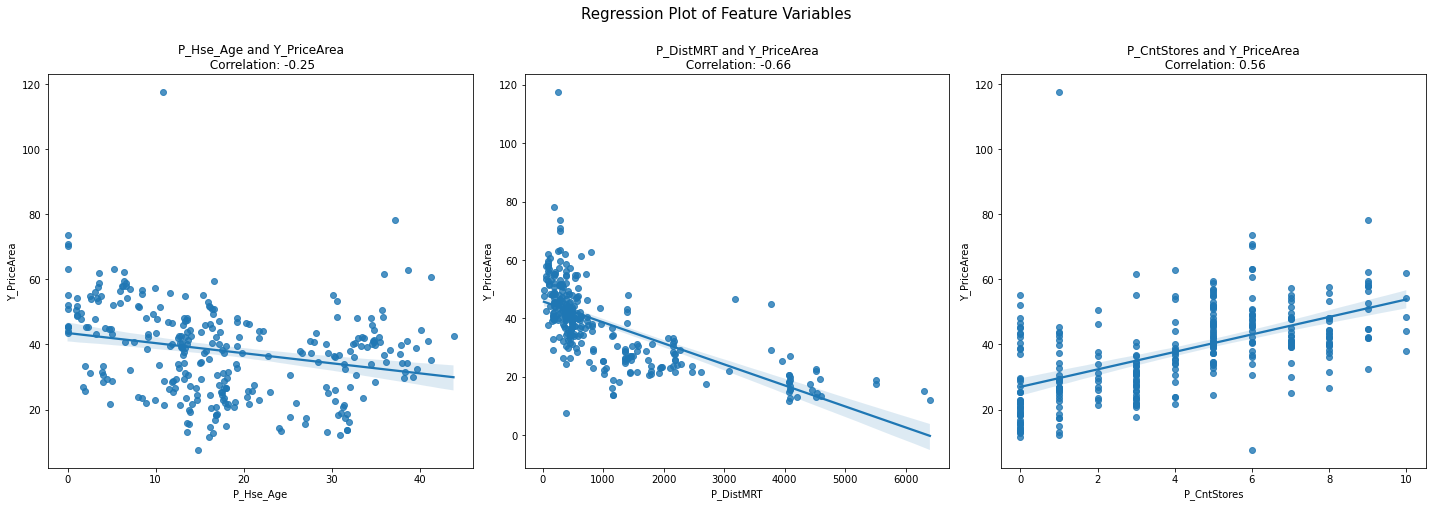

In [12]:
# regression plot prior transformations
reg_plot(house_sold_Xy, X)

As the feature variables have a weak and moderate linear relationship with the target variable, feature transformations are needed.

**Linearity Test - Transformation**

I created a function that will determine which among the transformations are best suited for a particular target variable based on the correlation coefficient. <br> Transformations that are compared includes `log transformation`, `box-cox transformation`and `square-root transformation`. <br>I also retained the correlation coefficient for the untransformed value to serve as a point of comparison

In [13]:
house_sold_Xy = house_sold_Xy.replace(0, 0.00001) # replace 0 values to avoid having -inf after transformation

# transform the feature variables
for col in X:
    correlations = best_transformation(house_sold_Xy, col)
    
    print(f'{col}: \n{correlations}')

    if correlations[max(correlations, key = correlations.get)] > 0:
        print(f'Best: {max(correlations, key = correlations.get)}\n')
    else:
        print(f'Best: {min(correlations, key = correlations.get)}\n')


P_Hse_Age: 
{'Log Transformation': -0.31, 'Boxcox Transformation': -0.33, 'Square Root Transformation': -0.33, 'No Transformation': -0.25}
Best: Boxcox Transformation

P_DistMRT: 
{'Log Transformation': -0.73, 'Boxcox Transformation': -0.73, 'Square Root Transformation': -0.72, 'No Transformation': -0.66}
Best: Log Transformation

P_CntStores: 
{'Log Transformation': 0.42, 'Boxcox Transformation': 0.52, 'Square Root Transformation': 0.55, 'No Transformation': 0.56}
Best: No Transformation



The best transformation for `P_Hse_Age` and `P_Dist_MRT` are `box-cox transformation` and `log transformation` respectively, whereas transformation is not required in `P_CntStores` ase the untransformed values has a higher correlation coefficient than that of the transformed values

In [14]:
# apply transformations

house_sold_Xy_t = house_sold_Xy.copy()
house_sold_Xy_t['P_Hse_Age'] = stats.boxcox(house_sold_Xy['P_Hse_Age'])[0]
house_sold_Xy_t['P_DistMRT'] = np.log(house_sold_Xy['P_DistMRT'])
house_sold_Xy_t['P_CntStores'] = house_sold_Xy['P_CntStores']
house_sold_Xy_t['Y_PriceArea'] = house_sold_Xy['Y_PriceArea']


****Linearity Test - After Transformation****

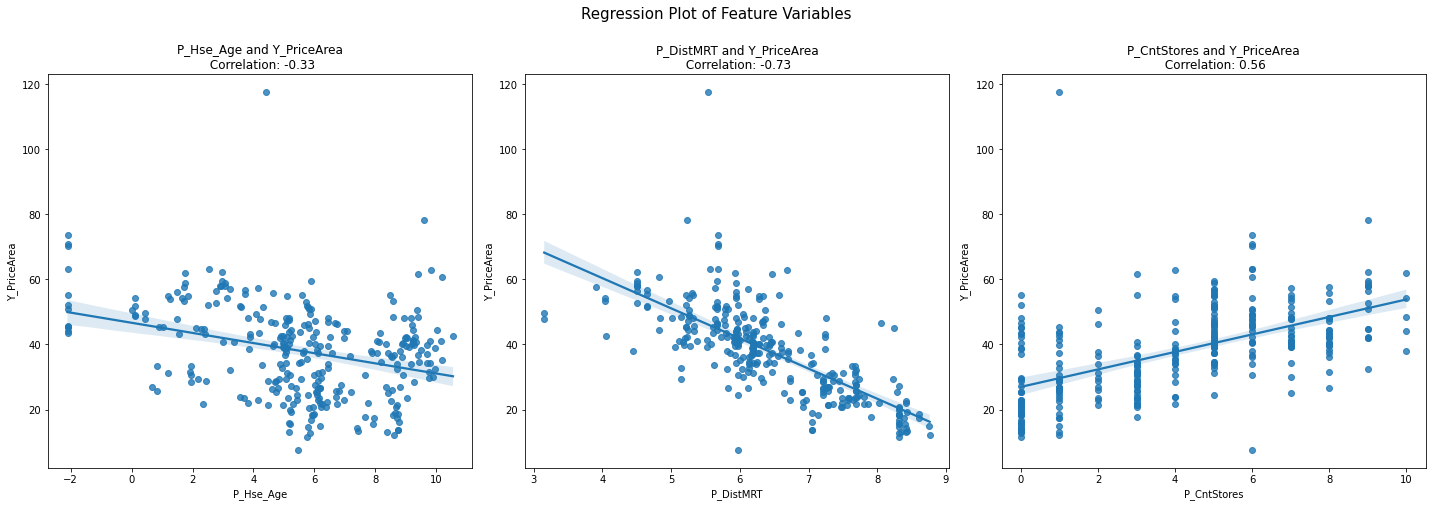

In [15]:
# regression plot after transformation
reg_plot(house_sold_Xy_t, X)

The linear relationship of the feature variables with the target variable improved after the trasformation

##### Outliers

**Outliers - Visualization**

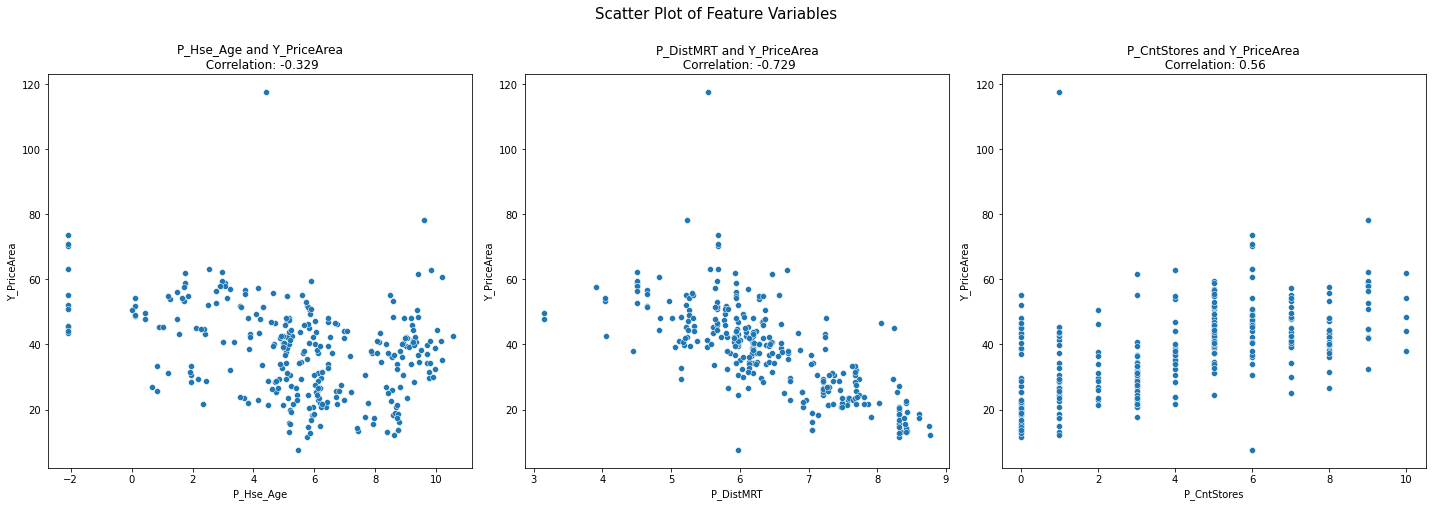

In [16]:
# scatter plot prior to removing the outliers
scatter_plot(house_sold_Xy_t, X)

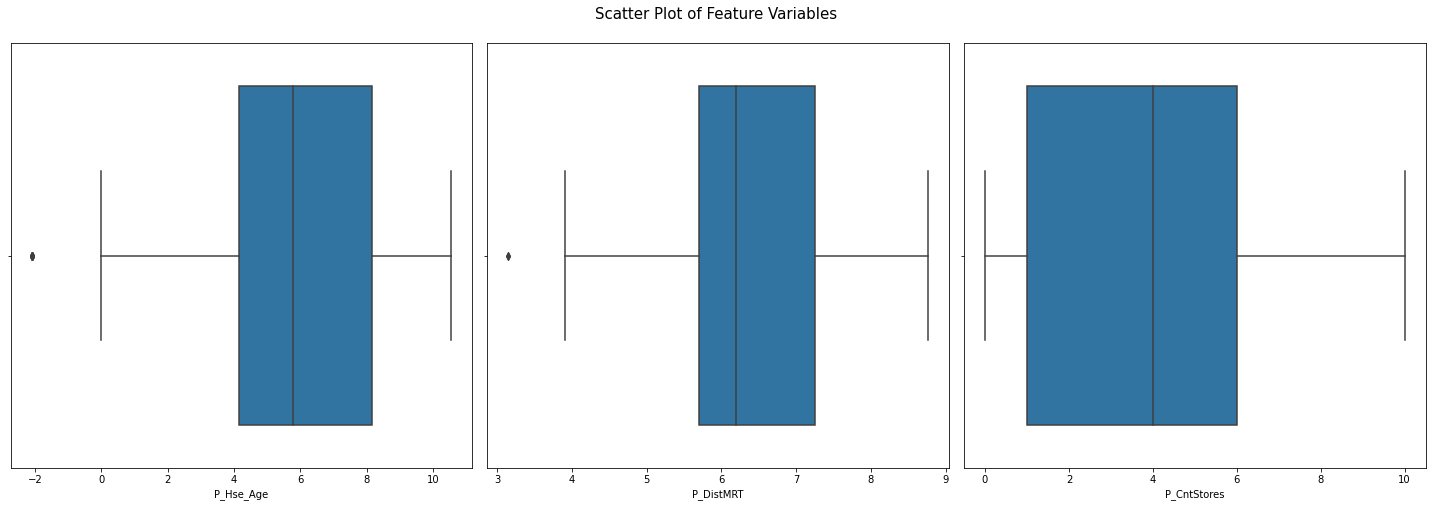

In [17]:
# box plot prior to removing the outliers
box_plot(house_sold_Xy_t, X)

**Outliers - Removal**

In [18]:
#remove outliers
print(f'Before removing outliers: {len(house_sold_Xy_t)}')
house_sold_Xy_t = removeoutliers(house_sold_Xy_t, 'P_Hse_Age')
house_sold_Xy_t = removeoutliers(house_sold_Xy_t, 'P_DistMRT')
house_sold_Xy_t = removeoutliers(house_sold_Xy_t, 'P_CntStores')
house_sold_Xy_t = house_sold_Xy_t[house_sold_Xy_t['Y_PriceArea'] <= 100]
print(f'After removing outliers: {len(house_sold_Xy_t)}')

Before removing outliers: 299
After removing outliers: 284


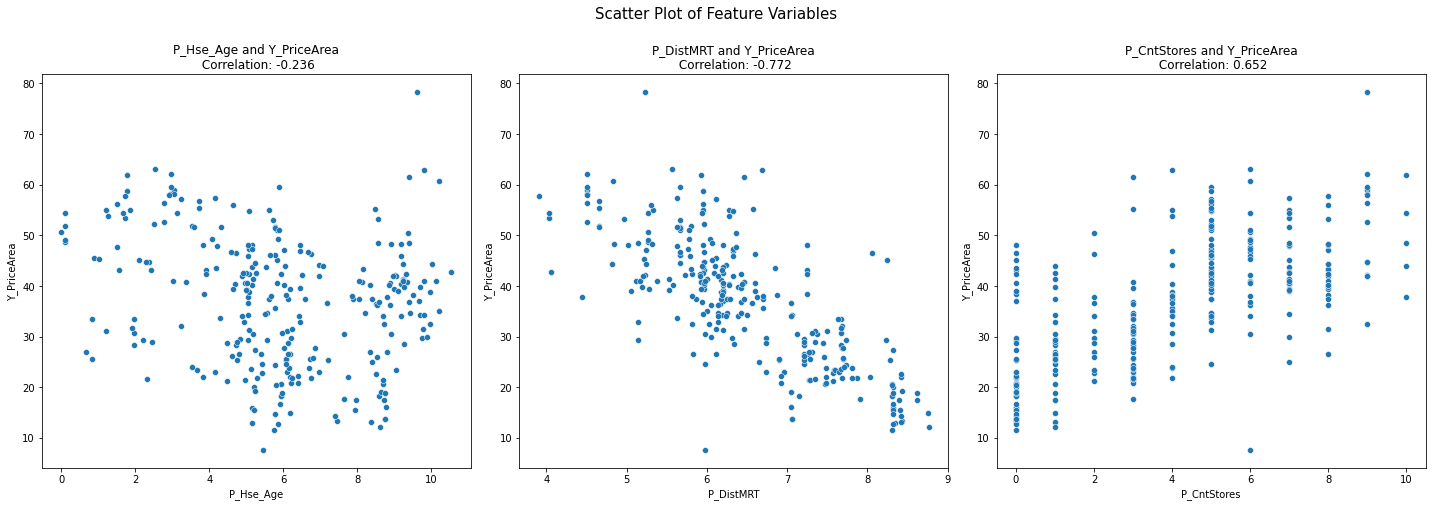

In [19]:
# scatter plot after removing outliers
scatter_plot(house_sold_Xy_t, X)

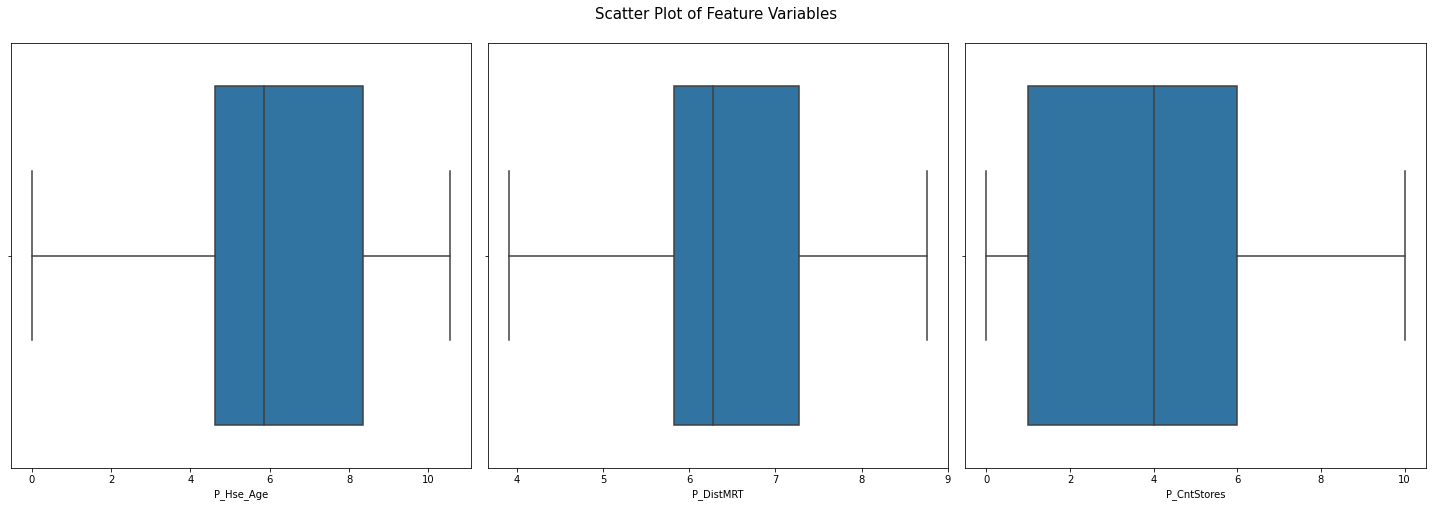

In [20]:
# box plot after removing outliers
box_plot(house_sold_Xy_t, X)

The presence of noticeable outliers in both the scatter plot and box plot are removed after dropping it

##### Multicollinearity

**Multicollinearity - Visualization**

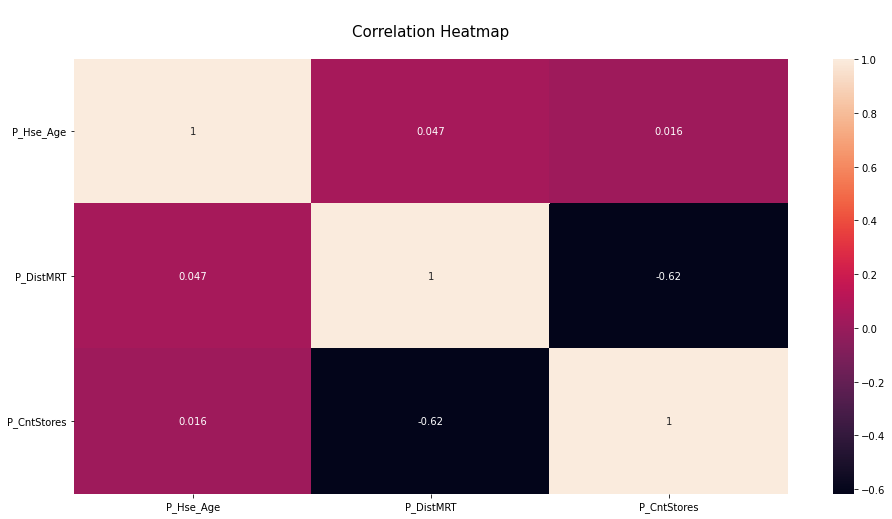

In [21]:
heatmap(house_sold, X)

Multi-collinearity is not present in the dataset as there are no features having a correlation coefficient greater than .70. <br> Therefore, the features are not highly correlated with each other.

#### Distribution

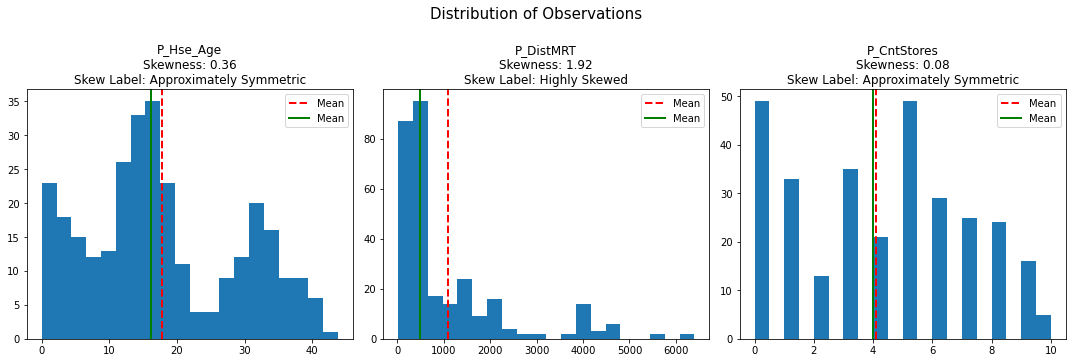

In [22]:
# histogram before removing outliers and transforming the features
histogram(house_sold, X)

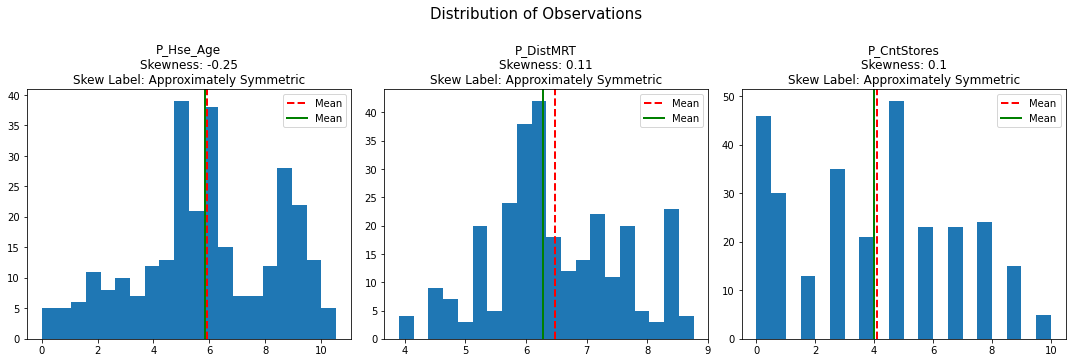

In [23]:
# histogram after removing outliers and transforming the features
histogram(house_sold_Xy_t, X)

The histogram plots above showed that the distribution of the features are all approximately symmetric after the transformations are made. <br> This proves the effectiveness of the pre-processing steps performed.

### Model Building

#### Model Building using `HousePrice_Sold` Dataset with `train_test_split` for **evaluation**

**Model 1 (Applying Best Transformation w/o Polynomial)**

In [24]:
# define variables
X = house_sold_Xy_t.drop(['Y_PriceArea'], axis = 1)
y = house_sold_Xy_t['Y_PriceArea']

# train test split
X_train, X_test, y_train, y_test_model1 = train_test_split(X,y, test_size=.33, random_state=123)

#model building
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_model1 = mlr.predict(X_test)

#model evaluation
result_model1 = evaluate(X_train, y_train, y_test_model1, y_pred_model1, 'Model 1')
print(result_model1)

                    Model 1
F-Statistic      124.973213
P-Value_X1   7.89094383e-03
P-Value_X2   5.42835606e-39
P-Value_X3   6.75281358e-23
R-Squared          0.668402
RMSE               7.341212


**Model 2 (Applying Best Transformation w/ 2nd degree Polynomial)**

In [25]:
# define variables
X = house_sold_Xy_t.drop(['Y_PriceArea'], axis = 1)
y = house_sold_Xy_t['Y_PriceArea']

# train test split
X_train, X_test, y_train, y_test_model2 = train_test_split(X,y, test_size=.33, random_state=123)

# create pipeline
pipe = Pipeline([("polynomial_features", PolynomialFeatures(2)),
                 ("linear_regression", LinearRegression())])

# fit the model
pipe.fit(X_train, y_train)

# predict
y_pred_model2 = pipe.predict(X_test)

# evaluate
result_model2 = evaluate(X_train, y_train, y_test_model2, y_pred_model2, 'Model 2')
print(result_model2)


                    Model 2
F-Statistic      124.500542
P-Value_X1   7.89094383e-03
P-Value_X2   5.42835606e-39
P-Value_X3   6.75281358e-23
R-Squared          0.667561
RMSE               7.350509


**Model 3 (Applying Log Transformation to all the Feature Variables w/ 2nd degree Polynomial)**

In [26]:
# remove outliers
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_Hse_Age')
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_DistMRT')
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_CntStores')
house_sold_Xy = house_sold_Xy[house_sold_Xy['Y_PriceArea'] <= 100]

# define variables
X = house_sold_Xy.drop(['Y_PriceArea'], axis = 1)
y = house_sold_Xy['Y_PriceArea']


# replace 0 values to avoid having -inf after transformation
X = X.replace(0, .00001)

# train test split
X_train, X_test, y_train, y_test_model3 = train_test_split(X,y, test_size=.30, random_state=123)

# create pipeline
pipe = Pipeline([("function_transformer", FunctionTransformer(np.log)),
                 ("scaler", StandardScaler()),
                 ("polynomial_features", PolynomialFeatures()),
                 ("linear_regression", LinearRegression())])

# define parameters to tune
params = {'polynomial_features__degree': [1, 2,3,4,5]}

# instantiate the Grid object
grid = GridSearchCV(pipe, params, cv = 5)

# fit the model
grid.fit(X_train, y_train)

# predit
y_pred_cv = grid.predict(X_test)

# evaluate the best parameter
grid.best_params_

{'polynomial_features__degree': 2}

In [27]:
# create pipeline based on the best parameter
pipe = Pipeline([("function_transformer", FunctionTransformer(np.log)),
                 ("scaler", StandardScaler()),
                 ("polynomial_features", PolynomialFeatures(2)),
                 ("linear_regression", LinearRegression())])

# fit the model
pipe.fit(X_train, y_train)

# predict
y_pred_model3 = pipe.predict(X_test)

# evaluate
result_model3 = evaluate(X_train, y_train, y_test_model3, y_pred_model3, 'Model 3')
print(result_model3)      

                    Model 3
F-Statistic      174.247973
P-Value_X1   1.11791283e-02
P-Value_X2   3.16114219e-20
P-Value_X3   2.32805100e-11
R-Squared           0.74175
RMSE               6.623549


#### Model Evaluation

In [28]:
# model results
results_all = result_model1.merge(result_model2, left_index = True, right_index = True)
results_all = results_all.merge(result_model3,left_index = True, right_index = True)
results_all

,Model 1,Model 2,Model 3
F-Statistic,124.973213,124.500542,174.247973
P-Value_X1,7.89094383e-03,7.89094383e-03,1.11791283e-02
P-Value_X2,5.42835606e-39,5.42835606e-39,3.16114219e-20
P-Value_X3,6.75281358e-23,6.75281358e-23,2.32805100e-11
R-Squared,0.668402,0.667561,0.74175
RMSE,7.341212,7.350509,6.623549


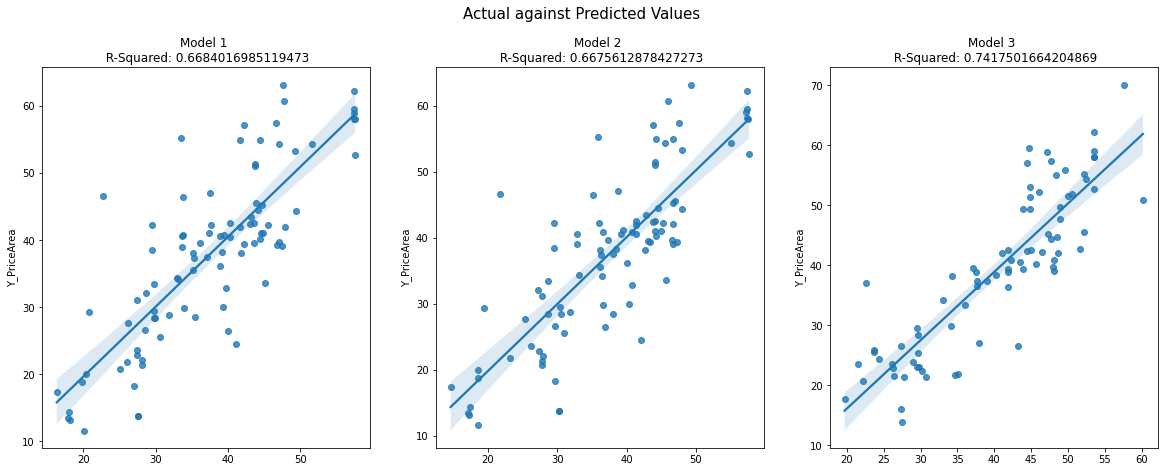

In [29]:
fig, axes = plt.subplots(1,3, figsize = (20,7))
plt.suptitle('Actual against Predicted Values', fontsize = 15, y = 1)

sns.regplot(x = y_pred_model1, y = y_test_model1, ax = axes[0])
axes[0].set_title(f'Model 1 \n R-Squared: {r2_score(y_test_model1, y_pred_model1)}')

sns.regplot(x = y_pred_model2, y = y_test_model2, ax = axes[1])
axes[1].set_title(f'Model 2 \n R-Squared: {r2_score(y_test_model2, y_pred_model2)}')

sns.regplot(x = y_pred_model3, y = y_test_model3, ax = axes[2])
axes[2].set_title(f'Model 3 \n R-Squared: {r2_score(y_test_model3, y_pred_model3)}')

plt.show()

#### Checking of Assumptions - Part 2

##### Normality of Residuals

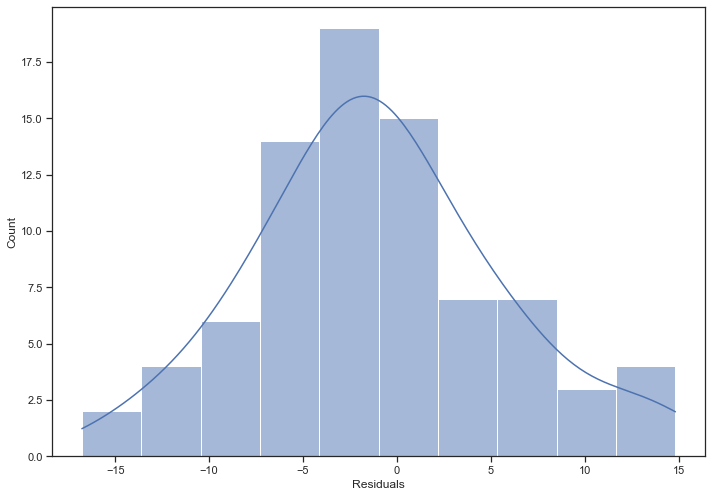

In [30]:
# checking for normality of residuals based on the best model (Model3)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('ticks')

residuals = y_test_model3 - y_pred_model3
sns.histplot(residuals, kde = True)

plt.xlabel('Residuals')
plt.show()

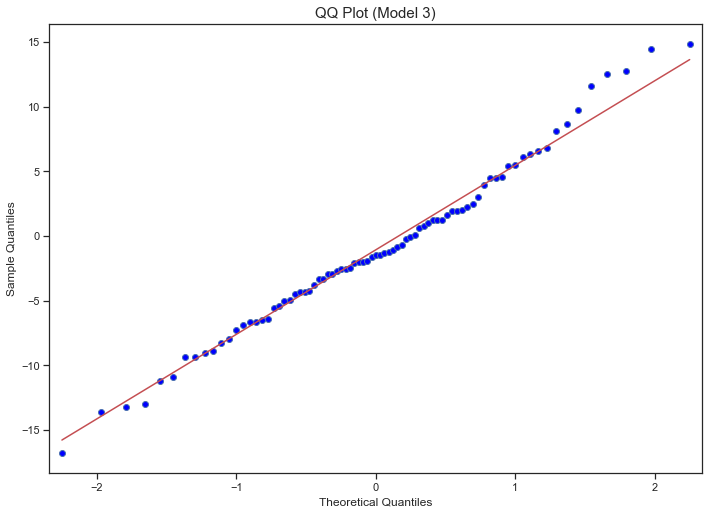

In [31]:
# checking for normality of residuals based on the best model (Model3)
errors_model3 = (y_test_model3 - y_pred_model3)

sm.qqplot(errors_model3, line = 's')

plt.title('QQ Plot (Model 3)', fontsize = 15)
plt.show()

##### Homoscedasticity

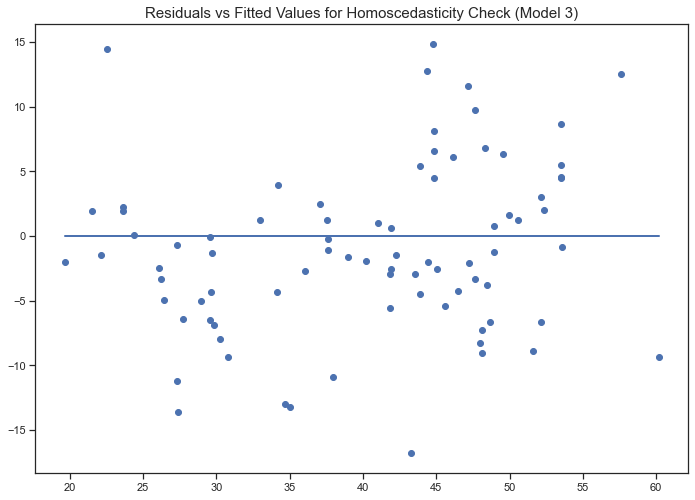

In [32]:
# checking for homoscedasticity based on the best model (Model3)

plt.scatter(x = y_pred_model3, y = errors_model3)
plt.plot(y_pred_model3, [0]*len(y_pred_model3))

plt.title('Residuals vs Fitted Values for Homoscedasticity Check (Model 3)', fontsize = 15)

plt.show()

#### Model Building using `HousePrice_Sold` Dataset without `train_test_split` Dataset for **prediction**

**Final Model (Applying the Best Model among the 3 Experiments on the entire `HousePrice_Sold` Dataset)**

In [33]:
# load dataset
house_sold = pd.read_excel('HousePrice_Sold.xlsx')
house_sold_Xy = house_sold.drop(columns = ['No', 'P_Lat', 'P_Lon'])

# remove outliers
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_Hse_Age')
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_DistMRT')
house_sold_Xy = removeoutliers(house_sold_Xy, 'P_CntStores')
house_sold_Xy = house_sold_Xy[house_sold_Xy['Y_PriceArea'] <= 100]

# define variables
X = house_sold_Xy.drop(['Y_PriceArea'], axis = 1)
y = house_sold_Xy['Y_PriceArea']

# replace 0 values to avoid having -inf after transformation
X = X.replace(0, .00001)

# create pipeline
final_model = Pipeline([("function_transformer", FunctionTransformer(np.log)),
                    ("scaler", StandardScaler()),
                    ("polynomial_features", PolynomialFeatures(2)),
                     ("linear_regression", LinearRegression())])

# fit the model
final_model.fit(X, y)

Pipeline(steps=[('function_transformer',
                 FunctionTransformer(func=<ufunc 'log'>)),
                ('scaler', StandardScaler()),
                ('polynomial_features', PolynomialFeatures()),
                ('linear_regression', LinearRegression())])

#### Predicting the `PriceArea` for the `HousePrice-New`

In [34]:
# load the dataset
house_new = pd.read_excel('HousePrice_New.xlsx')

X_new = house_new[['P_Hse_Age', 'P_DistMRT', 'P_CntStores']]
X_new = X_new.replace(0,0.00001)

y_pred = final_model.predict(X_new)

house_new['Ypred_PriceArea'] = y_pred
house_new

,No,P_Hse_Age,P_DistMRT,P_CntStores,P_Lat,P_Lon,Y_PriceArea,Ypred_PriceArea
0,301,2.5,156.24420,4,24.96696,121.53992,NaN,51.958652
1,302,38.0,461.78480,0,24.97229,121.53445,NaN,27.148802
2,303,16.5,2288.01100,3,24.95885,121.51359,NaN,22.943925
3,304,38.3,439.71050,0,24.97161,121.53423,NaN,27.174426
4,305,20.0,1626.08300,3,24.96622,121.51668,NaN,26.562356
...,...,...,...,...,...,...,...,...
109,410,13.7,4082.01500,0,24.94155,121.50381,NaN,21.064007
110,411,5.6,90.45606,9,24.97433,121.54310,NaN,53.941945
111,412,18.8,390.96960,7,24.97923,121.53986,NaN,43.701610
112,413,8.1,104.81010,5,24.96674,121.54067,NaN,50.579671


In [35]:
house_new.to_excel('Appendix II.xlsx')